In [608]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [609]:
def generalise_X_matrix(X, degree):
    '''
    Function for Generating Input Matrix (generalise for multivariate polynomial regression)
    '''

    n_samples, n_features = X.shape
    features = []
    features.append(np.ones(n_samples))  # Add x^0 term

    # Generate polynomial features
    for d in range(1, degree + 1):
        current_degree_features = []
        
        # Generate features for each individual feature raised to the current degree
        for i in range(n_features):
            current_degree_features.append(X[:, i] ** d)

        # Generate interaction terms for current degree (only if d > 1)
        if d > 1:
            for i in range(n_features):
                for j in range(i + 1, n_features):  # Start from i + 1 to avoid self-interaction
                    interaction_term = (X[:, i] ** (d - 1)) * (X[:, j] ** 1)
                    current_degree_features.append(interaction_term)

        # Add current degree features to the main features list
        features.extend(current_degree_features)

    return np.column_stack(features)

In [610]:
def estimate_B(X, Y):
    '''
    Estimate Parameters Using OLS
    '''
    B = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    
    return B

In [611]:
def k_fold_cross_validation(X, Y, k, degrees):
    '''
    Function for k-fold cross-validation with random shuffling
    '''

    # Shuffle the indices of the dataset randomly
    indices = np.arange(len(Y))
    np.random.shuffle(indices)

    fold_size = len(Y) // k
    ssr_results_val = {degree: [] for degree in degrees}
    ssr_results_train = {degree: [] for degree in degrees}
    R2_results_train = {degree: [] for degree in degrees}
    R2_results_val = {degree: [] for degree in degrees}

    for degree in degrees:
        # Create polynomial features
        X_poly = generalise_X_matrix(X, degree)

        for fold in range(k):
            # Get validation indices for the current fold
            val_indices = indices[fold * fold_size : (fold + 1) * fold_size]

            # Get training indices as the remaining indices
            train_indices = np.setdiff1d(indices, val_indices)

            X_train, Y_train = X_poly[train_indices], Y[train_indices]
            X_val, Y_val = X_poly[val_indices], Y[val_indices]

            # Estimate parameters and predict
            B = estimate_B(X_train, Y_train)
            Y_pred_val = X_val @ B
            Y_pred_train = X_train @ B

            # Calculate SSR for the validation & training set
            ssr_val = np.sum((Y_val - Y_pred_val) ** 2)
            ssr_results_val[degree].append(ssr_val)

            ssr_train = np.sum((Y_train - Y_pred_train) ** 2)
            ssr_results_train[degree].append(ssr_train)

            # Calculate R^2 for the validation & training set
            SSy_train = np.sum((Y_train - np.mean(Y_train)) ** 2)
            R2_train = 1 - (ssr_train / SSy_train)
            R2_results_train[degree].append(R2_train)

            SSy_val = np.sum((Y_val - np.mean(Y_val)) ** 2)
            R2_val = 1 - (ssr_val / SSy_val)
            R2_results_val[degree].append(R2_val)

    # Average SSR & R2 for each degree
    avg_ssr_val = {degree: np.mean(ssrs) for degree, ssrs in ssr_results_val.items()}
    avg_ssr_train = {degree: np.mean(ssrs) for degree, ssrs in ssr_results_train.items()}
    avg_r2_train = {degree: np.mean(r2s) for degree, r2s in R2_results_train.items()}
    avg_r2_val = {degree: np.mean(r2s) for degree, r2s in R2_results_val.items()}

    return avg_ssr_val, avg_ssr_train, avg_r2_val, avg_r2_train

In [612]:
# Load data
data = pd.read_csv('train.csv')
train_x = data['x'].to_numpy()
train_y = data['y'].to_numpy()

In [613]:
# Set seed for reproducibility
np.random.seed(60)

# Parameters for k-fold
k = 5
degrees = range(1, 23)

# Perform k-fold cross-validation
avg_ssr_val, avg_ssr_train, avg_r2_val, avg_r2_train = k_fold_cross_validation(train_x.reshape(-1,1), train_y, k, degrees)

# Identify the best degree
best_degree = min(avg_ssr_val, key=avg_ssr_val.get)
print(f"Best polynomial degree: {best_degree}")

Best polynomial degree: 5


In [614]:
# Get the indices that would sort x
sorted_indices = np.argsort(train_x) 
x_sorted = train_x[sorted_indices]   
y_sorted = train_y[sorted_indices]

In [615]:
# Make Input Matrix
X_train = generalise_X_matrix(x_sorted.reshape(-1, 1), best_degree)

# Estimate Parameters For Training Data
B = estimate_B(X_train, y_sorted)
print("Estimated Parameters: ",B)

# Predict Outputs
pred_y_train = X_train @ B

Estimated Parameters:  [ 83.63591607   2.44833307  20.4101032  -10.82732749  -3.21687742
   0.57237938]


In [616]:
# SSR for Best degree
ssr_train = np.sum((pred_y_train - y_sorted) ** 2)
print(f'SSR: {ssr_train}')

# Save the parameters to a file
with open('3_weights.pkl', 'wb') as f:
    pickle.dump(B, f)

SSR: 235760.15949992897


In [617]:
# Load test data
test_data = pd.read_csv('test.csv')  
test_x = test_data[['x']].to_numpy()
test_id = test_data['id'].to_numpy()

# Create polynomial features for test data
X_test = generalise_X_matrix(test_x, best_degree)

# Make predictions on the test set
test_predictions = X_test @ B

# Save test predictions to CSV
test_output = pd.DataFrame({'id': test_id, 'x': test_x.flatten(), 'y': test_predictions.flatten()})
test_output.to_csv('test_predictions.csv', index=False)

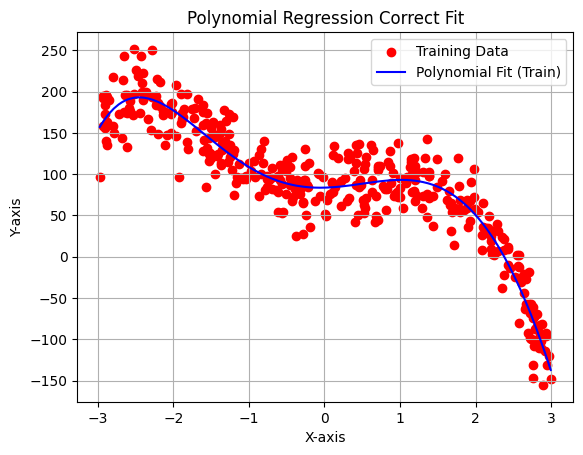

In [618]:
# Plotting Correct Polynomial fit
plt.scatter(x_sorted, y_sorted, color='red', label='Training Data')
plt.plot(x_sorted, pred_y_train, color='blue', label='Polynomial Fit (Train)')
plt.title('Polynomial Regression Correct Fit')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()


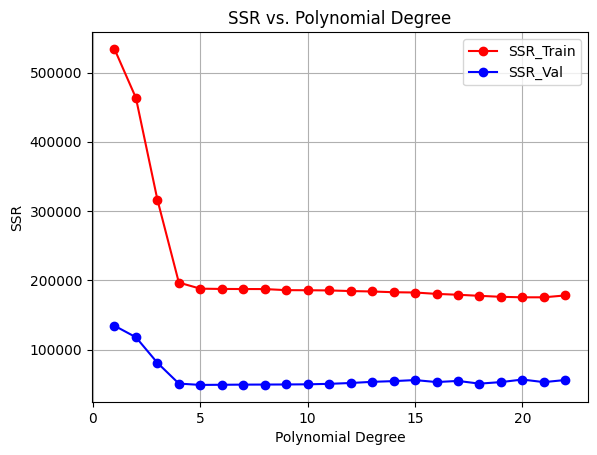

In [619]:
# Plotting of SSR
plt.plot(degrees, list(avg_ssr_train.values()), marker = 'o', color='red', label='SSR_Train')
plt.plot(degrees, list(avg_ssr_val.values()), marker = 'o', color='blue', label='SSR_Val')
plt.title('SSR vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('SSR')
# plt.yscale('log')
plt.legend()
plt.grid()

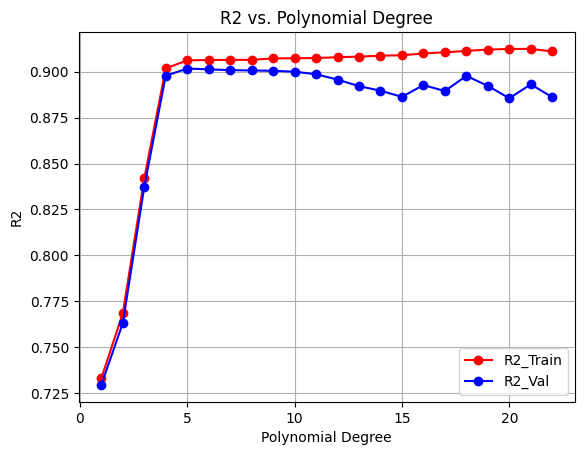

In [620]:
# Plotting of SSR
plt.plot(degrees, list(avg_r2_train.values()), marker = 'o', color='red', label='R2_Train')
plt.plot(degrees, list(avg_r2_val.values()), marker = 'o', color='blue', label='R2_Val')
plt.title('R2 vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R2')
# plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1])
plt.legend()
plt.grid()

In [621]:
#Underfit and Overfit
# R2 and SSR value for training set for degree 2 is min and max(other than degree 1) respectively(take 1-3 degree for underfit)
X_train_underfit = generalise_X_matrix(x_sorted.reshape(-1, 1), 2)
B_underfit = estimate_B(X_train_underfit, y_sorted)
pred_y_underfit = X_train_underfit @ B_underfit

# R2 and SSR value for training set for degree 20 is max and min respectively  
X_train_overfit = generalise_X_matrix(x_sorted.reshape(-1, 1), 20)
B_overrfit = estimate_B(X_train_overfit, y_sorted)
pred_y_overfit = X_train_overfit @ B_overrfit
print(np.sum((pred_y_overfit - y_sorted) ** 2))

222402.36072962184


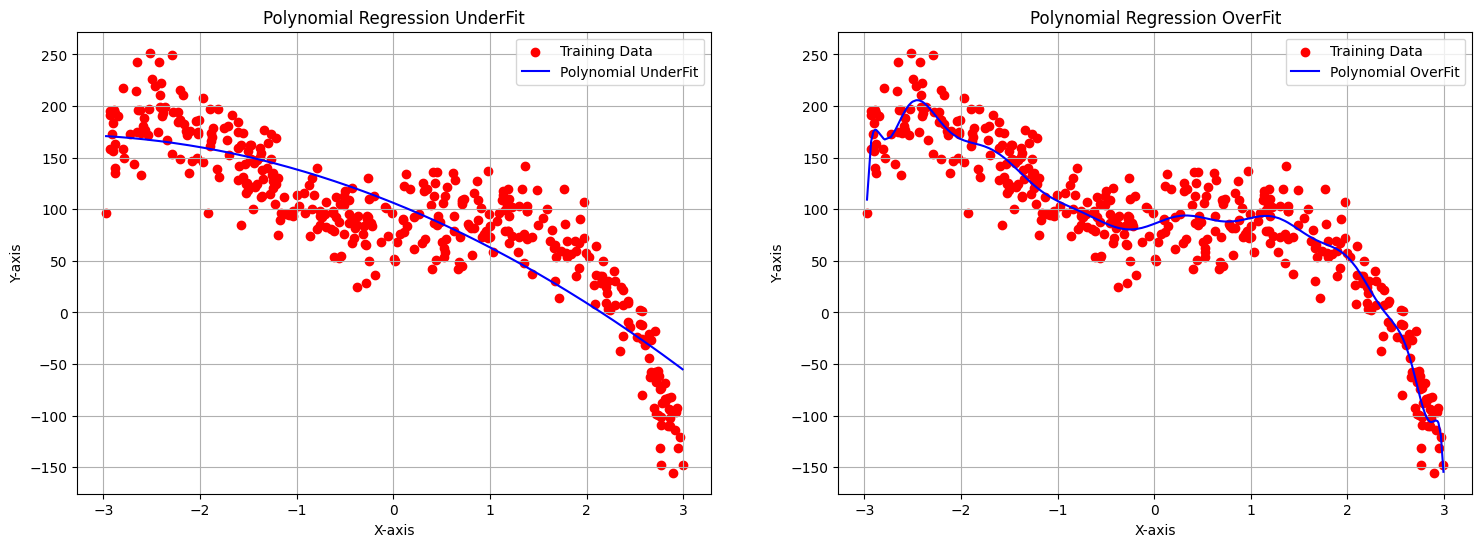

In [622]:
# Plotting Underfit Polynomial fit
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.scatter(x_sorted, y_sorted, color='red', label='Training Data')
plt.plot(x_sorted, pred_y_underfit, color='blue', label='Polynomial UnderFit')
plt.title('Polynomial Regression UnderFit')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()

# Plotting Overfit Polynomial fit
plt.subplot(1,2,2)
plt.scatter(x_sorted, y_sorted, color='red', label='Training Data')
plt.plot(x_sorted, pred_y_overfit, color='blue', label='Polynomial OverFit')
plt.title('Polynomial Regression OverFit')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()
plt.show()